# Language Detection on the Edge

## Imports

In [1]:
# Imports
import wave
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, AvgPool1D, MaxPool1D, ZeroPadding1D, BatchNormalization, Flatten, Dense, Activation, GlobalAveragePooling1D
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import kerascnn2c
from pathlib import Path
import copy

from sklearn.preprocessing import MinMaxScaler

## Pre-process Data

### Helper Functions

In [2]:
def create_data(dataset_dir: str, file_names: list):

    NUM_CLASSES = len(file_names)
    
    x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
    for enum, file in enumerate(file_names):
        path = dataset_dir + file + '.pkl'
        with open(path, 'rb') as data_file:
            data = pickle.load(data_file)

            data_train = data['data_train']
            data_test = data['data_test']
            data_val = data['data_val']

        sample_rate=16000

        x_train_inter = []
        for i in data_train:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_train_inter.extend(np.split(array_intermediate, num_sec))
        
        
        # x_test_inter = []
        # for i in data_test:
        #     num_sec = int(i.shape[0]/sample_rate)
        #     array_intermediate = i[:(num_sec*sample_rate)]
        #     x_test_inter.extend(np.split(array_intermediate, num_sec))

        # x_val_inter = []
        # for i in data_val:
        #     num_sec = int(i.shape[0]/sample_rate)
        #     array_intermediate = i[:(num_sec*sample_rate)]
        #     x_val_inter.extend(np.split(array_intermediate, num_sec))

        y_train_inter = [[enum]]*len(x_train_inter)
        # y_test_inter = [[enum]]*len(x_test_inter)
        # y_val_inter = [[enum]]*len(x_val_inter)

        x_train.extend(x_train_inter)
        # x_test.extend(x_test_inter)
        # x_val.extend(x_val_inter)

        y_train.extend(y_train_inter)
        # y_test.extend(y_test_inter)
        # y_val.extend(y_val_inter)
        

    x_train = np.array(x_train)
    # x_test = np.array(x_test)
    # x_val = np.array(x_val)

    y_train = to_categorical(np.array(y_train), num_classes = NUM_CLASSES)
    # y_test = to_categorical(np.array(y_test), num_classes = NUM_CLASSES)
    # y_val = to_categorical(np.array(y_val), num_classes = NUM_CLASSES)

    # return x_train, x_test, x_val, y_train, y_test, y_val
    return x_train, y_train
    
def load_data(dir_path: str):
    with open(dir_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    return data

def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x


### Loading Data

In [3]:
# dataset_dir = '../../data/pre-train/raw/'
dataset_dir = '../../data/pre-train/'
CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr']

# x = load_data(dataset_dir+'x_train.pkl')
# y = load_data(dataset_dir+'y_train.pkl')

x = load_data(dataset_dir+'x_all.pkl')
y = load_data(dataset_dir+'y_all.pkl')

# x = load_data(dataset_dir+'x_val.pkl')
# y = load_data(dataset_dir+'y_val.pkl')
print('Data successfully loaded')


permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]
print('Data successfully permutated')

x = x[:int(0.5*len(x)),:]
y = y[:int(0.5*len(y)),:]
print('Data successfully shortened')

min_int16 = fixed_point_conversion(-(2**15), 9)
max_int16 = fixed_point_conversion((2**15)-1, 9)

scaler = MinMaxScaler(feature_range=(min_int16, max_int16))
x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])
print('Data successfully scaled')

# x_test = load_data(dataset_dir+'x_test.pkl')
# x_val = load_data(dataset_dir+'x_val.pkl')
# y_test = load_data(dataset_dir+'y_test.pkl')
# y_val = load_data(dataset_dir+'y_val.pkl')

# print('----------------------------------------------------------------------')
# print(f'Number of samples in train: {len(x_train)}')
# print(f'Number of samples in test: {len(x_test)}')
# print(f'Number of samplesin validation: {len(x_val)}')
# print('----------------------------------------------------------------------')
# print('----------------------------------------------------------------------')
# print(f'x_train shape: {x_train.shape} | y_train shape: {y_train.shape}')
# print(f'x_test shape: {x_test.shape} | y_test shape: {y_test.shape}')
# print(f'x_val shape: {x_val.shape} | y_val shape: {y_val.shape}')
# print('----------------------------------------------------------------------')

Data successfully loaded
Data successfully permutated
Data successfully shortened
Data successfully scaled


In [4]:
# splitting into training and validation data
train_split = int(0.8*len(x))

x_train, x_val = x[:train_split,:], x[train_split:,:]
y_train, y_val = y[:train_split,:], y[train_split:,:]

del x
del y

print(f'X train: {x_train.shape}')
print(f'X val: {x_val.shape}')
print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (61412, 16000, 1)
X val: (15354, 16000, 1)
y train: (61412, 5)
y val: (15354, 5)


In [5]:
# with open(f'../data/pre-train/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# f.close()

# with open(f'../data/pre-train/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# f.close()

# with open(f'../data/pre-train/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)
# f.close()

# with open(f'../data/pre-train/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# f.close()

# with open(f'../data/pre-train/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
# f.close()

# with open(f'../data/pre-train/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# f.close()

## Analysis of Training Data

--------------------------------COUNT EN---------------------------------
Train	 EN: 10305
Val	 EN: 2523
--------------------------------COUNT DE---------------------------------
Train	 DE: 12414
Val	 DE: 3122
--------------------------------COUNT ES---------------------------------
Train	 ES: 12183
Val	 ES: 2965
--------------------------------COUNT FR---------------------------------
Train	 FR: 14242
Val	 FR: 3617
--------------------------------COUNT IT---------------------------------
Train	 IT: 12268
Val	 IT: 3127
-------------------------------------------------------------------------
--------------------------------MINIMUM COUNTS---------------------------------
Min count train: 10305
Min count val: 2523
-------------------------------------------------------------------------


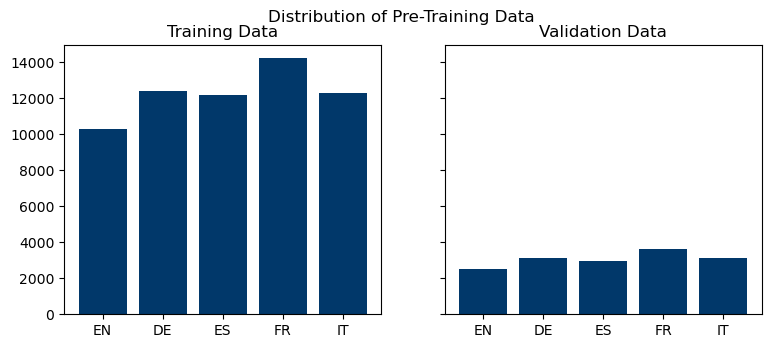

In [6]:

labels_train = [np.argmax(i) for i in y_train]
# labels_test = [np.argmax(i) for i in y_test]
labels_val = [np.argmax(i) for i in y_val]

unique_train, counts_train = np.unique(labels_train, return_counts=True)
# unique_test, counts_test = np.unique(labels_test, return_counts=True)
unique_val, counts_val = np.unique(labels_val, return_counts=True)

del labels_train
# del labels_test
del labels_val

# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']
LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']




fig, axes = plt.subplots(1,2, figsize=(9, 3.5), sharey=True, edgecolor='black')
axes[0].bar(LABELS, counts_train, color='#01386a')
axes[0].set_title('Training Data')

axes[1].bar(LABELS, counts_val, color='#01386a')
axes[1].set_title('Validation Data')

# axes[2].bar(LABELS, counts_test, color='#01386a')
# axes[2].set_title('Testing Data')

fig.suptitle('Distribution of Pre-Training Data')


for enum, i in enumerate(counts_train):
    print(f'--------------------------------COUNT {LABELS[enum]}---------------------------------')
    print(f'Train\t {LABELS[enum]}: {i}')
    # print(f'Test\t {LABELS[enum]}: {counts_test[enum]}')
    print(f'Val\t {LABELS[enum]}: {counts_val[enum]}')
print('-------------------------------------------------------------------------')

print('--------------------------------MINIMUM COUNTS---------------------------------')
print(f'Min count train: {min(counts_train)}')
# print(f'Min count test: {min(counts_test)}')
print(f'Min count val: {min(counts_val)}')
print('-------------------------------------------------------------------------')

## Preparing Data for Training

In [8]:
# perms = np.random.permutation(len(y_test))[0:250]
# x_test_250 = x_test[perms]
# y_test_250 = y_test[perms]
# np.savetxt('x_test_gsc_250.csv', x_test_250.reshape((x_test_250.shape[0], -1)), delimiter=',', fmt='%s')
# np.savetxt('y_test_gsc_250.csv', y_test_250, delimiter=',', fmt='%s')



## Build model

In [7]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
model = Sequential()
model.add(Input(shape=(16000, 1)))
model.add(Conv1D(filters=8, kernel_size=20, strides=10,activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=8, strides=4, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, strides=2, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(AvgPool1D(4))
model.add(Flatten())
# model.add(Dense(units=128))
model.add(Dense(units=5))
model.add(Activation('softmax'))

# EXPLORE Learning Rate
earlystopping = EarlyStopping(monitor = "val_loss", patience  = 5)
opt = tf.keras.optimizers.Adam(lr=10e-4, decay = 10e-6)

model_path = '../models/language-detection-full-data/pre-trained'
model_name = 'language-detection-0.6'

# EARLY STOPPING
callback_path = f'{model_path}/checkpoints/{model_name}.ckpt' # save weights to this directory
checkpoint = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_best_only=True)

model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-01 15:27:04.367443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 15:27:04.369200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1599, 8)           168       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 799, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 32)            2080      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 32)           0

/opt/homebrew/Caskroom/miniforge/base/envs/embeddedAI/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), callbacks=[earlystopping, checkpoint])


Epoch 1/50


2023-05-01 15:27:51.467551: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-01 15:27:52.278056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


480/480 [==============================] - ETA: 0s - loss: 1.2965 - categorical_accuracy: 0.4577

2023-05-01 15:28:08.811661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.09753, saving model to ../models/language-detection-full-data/pre-trained/checkpoints/language-detection-0.6.ckpt
480/480 [==============================] - 19s 37ms/step - loss: 1.2965 - categorical_accuracy: 0.4577 - val_loss: 1.0975 - val_categorical_accuracy: 0.5781
Epoch 2/50
480/480 [==============================] - ETA: 0s - loss: 1.0037 - categorical_accuracy: 0.6173
Epoch 2: val_loss improved from 1.09753 to 0.97450, saving model to ../models/language-detection-full-data/pre-trained/checkpoints/language-detection-0.6.ckpt
480/480 [==============================] - 10s 22ms/step - loss: 1.0037 - categorical_accuracy: 0.6173 - val_loss: 0.9745 - val_categorical_accuracy: 0.6246
Epoch 3/50
479/480 [============================>.] - ETA: 0s - loss: 0.9023 - categorical_accuracy: 0.6592
Epoch 3: val_loss improved from 0.97450 to 0.88072, saving model to ../models/language-detection-full-data/pre-trained/checkpoints/language-detection-0.6.c

In [10]:
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/language-detection-full-data/pre-trained/assets


INFO:tensorflow:Assets written to: ../models/language-detection-full-data/pre-trained/assets


480/480 [==============================] - 2s 3ms/step


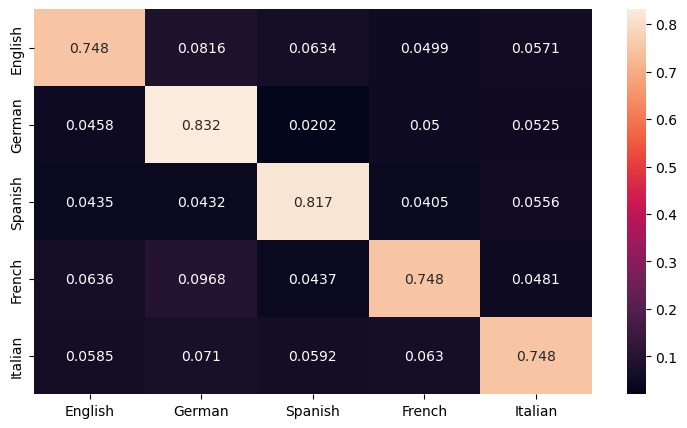

In [27]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

preds = model.predict(x_val)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_val.argmax(axis=-1), y_pred = y_classes, normalize='true')

NAMES = ['English', 'German', 'Spanish', 'French', 'Italian']

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=NAMES, yticklabels=NAMES)
plt.show()

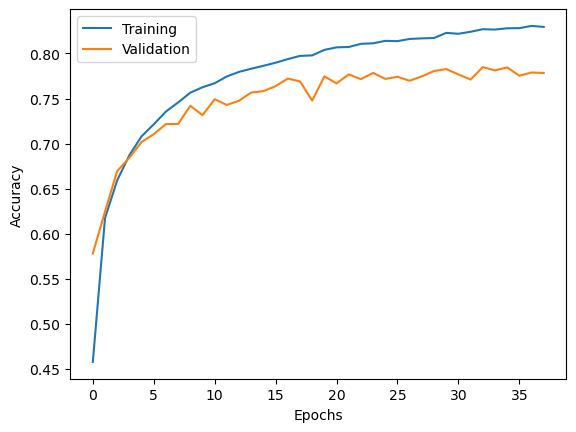

In [12]:
plt.plot(range(0, len(history.history['categorical_accuracy'])), history.history['categorical_accuracy'])
plt.plot(range(0, len(history.history['val_categorical_accuracy'])), history.history['val_categorical_accuracy'])
# plt.axis([0, range(0, len(history.history['val_categorical_accuracy'])), 0, 1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', 'Validation'])
plt.show()

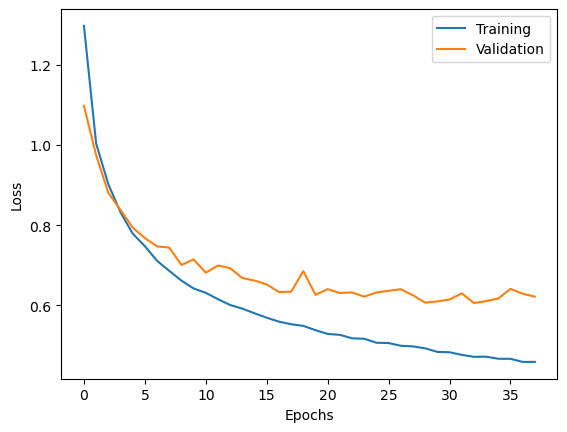

In [13]:
plt.plot(range(0, len(history.history['loss'])), history.history['loss'])
plt.plot(range(0, len(history.history['val_loss'])), history.history['val_loss'])
# plt.axis([0, range(0, len(history.history['val_loss'])), 0, 1])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])
plt.show()

In [14]:
# with tf.device('/gpu:0'):
#     model.evaluate(x_test, y_test, verbose=2)
#     pred_test = model.predict(x_test)
#     print(tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1)))

## Save trained model

In [15]:
model.save(f'{model_path}/{model_name}/keras2c/gsc_no_globalavg.h5')

In [16]:
# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [17]:
FIXED_POINT=9
res = kerascnn2c.Converter(output_path=Path(f'{model_path}/{model_name}/keras2c/gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open(f'{model_path}/{model_name}/keras2c/gsc_model_fixed.h', 'w') as f:
    f.write(res)

INFO:tensorflow:Assets written to: ram://c3ed22c9-dfd8-4154-bf0c-61e06139ea1f/assets


INFO:tensorflow:Assets written to: ram://c3ed22c9-dfd8-4154-bf0c-61e06139ea1f/assets


———————————————————————————————————————————————————————————————————————————————————————————————————————
Inputs                           | Layer                            | Outputs                         
———————————————————————————————————————————————————————————————————————————————————————————————————————
                                 | input_1                          | conv1d                          
-------------------------------------------------------------------------------------------------------
input_1                          | conv1d                           | max_pooling1d                   
-------------------------------------------------------------------------------------------------------
conv1d                           | max_pooling1d                    | conv1d_1                        
-------------------------------------------------------------------------------------------------------
max_pooling1d                    | conv1d_1                         